# SWMT on shelf for PanAntarctic 1/10th

In [2]:
import intake
import cosima_cookbook as cc
import glob

import cartopy.crs as ccrs
import cf_xarray as cfxr
import cmocean as cm
import dask.distributed
import gsw
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import matplotlib.colors as mcolors
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import pdb
import os
import pathlib
import shutil

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [3]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)

2025-09-16 09:53:28,080 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:34321'.
2025-09-16 09:53:28,083 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:35817'.
2025-09-16 09:53:28,084 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:35875'.
2025-09-16 09:53:28,086 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:46039'.
2025-09-16 09:53:28,088 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:33719'.
2025-09-16 09:53:28,090 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:38397'.
2025-09-16 09:53:28,092 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:40485'.
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-2536112' coro=

## Opening the saved data

In [4]:
# Importing the saved files
salt_files_C = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_*'))
heat_files_C = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_*'))

salt_files_M = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_*'))
heat_files_M = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_*'))

In [5]:
salt_tr_C = xr.open_mfdataset(salt_files_C, concat_dim='time', combine='nested', chunks={'time': 1, 'yh': 100, 'xh': 100})
heat_tr_C = xr.open_mfdataset(heat_files_C, concat_dim='time', combine='nested', chunks={'time': 1, 'yh': 100, 'xh': 100})
salt_tr_C = salt_tr_C.to_array().squeeze()
heat_tr_C = heat_tr_C.to_array().squeeze()

In [6]:
salt_tr_M = xr.open_mfdataset(salt_files_M, concat_dim='time', combine='nested', chunks={'time': 1, 'yh': 100, 'xh': 100})
heat_tr_M = xr.open_mfdataset(heat_files_M, concat_dim='time', combine='nested', chunks={'time': 1, 'yh': 100, 'xh': 100})
salt_tr_M = salt_tr_M.to_array().squeeze()
heat_tr_M = heat_tr_M.to_array().squeeze()

In [7]:
net_tr_C = salt_tr_C + heat_tr_C
net_tr_M = salt_tr_M + heat_tr_M

#### Antarctic shelf dense water formation

In [8]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [9]:
lat_slice = slice(None, -59)
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output040/20030901.ocean_static.nc')['deptho'].sel(yh=lat_slice)
area = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output040/20030901.ocean_static.nc')['areacello'].sel(yh=lat_slice)
varr = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output040/20030901.ocean_month_z.nc')['so'].sel(yh=lat_slice).isel(z_l=0,time=0)

land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

In [10]:
area_corr = (area*(varr*0+1))
area_corr = area_corr.drop_vars(['time','z_l'])
area_corr

<xarray.DataArray (yh: 510, xh: 3600)> Size: 7MB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [32539536., 32539536., 32539536., ..., 32539536., 32539536.,
        32539536.],
       [32637156., 32637156., 32637156., ..., 32637156., 32637156.,
        32637156.],
       [32735016., 32735016., 32735016., ..., 32735016., 32735016.,
        32735016.]], dtype=float32)
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -81.11 -81.07 -81.02 ... -59.14 -59.08 -59.03

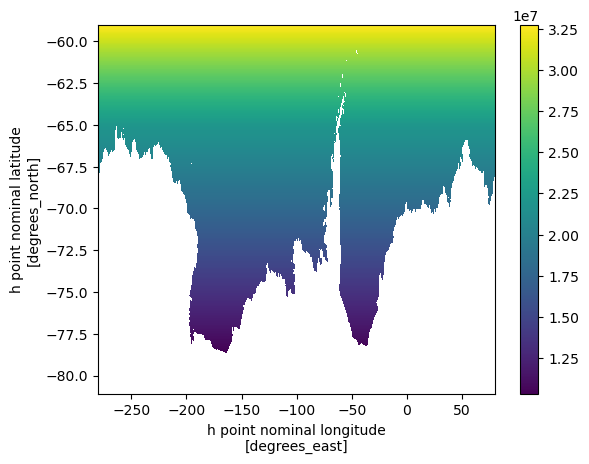

In [11]:
# Check mask
area_corr.plot()

Corrected area not needed because it is already being multiplied with a variable with the correct mask below?

In [12]:
# 25% and 75% thresholds
## Replace when using new data
cont_d25 = 27.89
cont_d75 = 27.73 

#### SWMT map

In [13]:
transformation_density = 27.73
shelf_subduction_plot_C = net_tr_C.sel(isopycnal_bins = transformation_density, method = 'nearest') * 1e5
swmt_xt_C = depth.cf['X']
swmt_yt_C = depth.cf['Y']

shelf_subduction_plot_M = net_tr_M.sel(isopycnal_bins = transformation_density, method = 'nearest') * 1e5
swmt_xt_M = depth.cf['X']
swmt_yt_M = depth.cf['Y']

In [14]:
shelf_subduction_plot_C

<xarray.DataArray (time: 10, yh: 510, xh: 3600)> Size: 147MB
dask.array<mul, shape=(10, 510, 3600), dtype=float64, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
    isopycnal_bins  float64 8B 27.73
  * xh              (xh) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yh              (yh) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
    z_l             float64 8B 0.5413
Dimensions without coordinates: time

In [15]:
shelf_subduction_plot_C.astype('float32').compute()

<xarray.DataArray (time: 10, yh: 510, xh: 3600)> Size: 73MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    isopycnal_bins  float64 8B 27.73
  * xh              (xh) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yh              (yh) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
    z_l             float64 8B 0.5413
Dimensions without coordinates: time

In [16]:
shelf_subduction_plot_M.astype('float32').compute()

<xarray.DataArray (time: 10, yh: 510, xh: 3600)> Size: 73MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    isopycnal_bins  float64 8B 27.73
  * xh              (xh) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yh              (yh) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
    z_l             float64 8B 0.5413
Dimensions without coordinates: time

In [17]:
## doing the anomaly
#anom_xt = swmt_xt_M.fillna(0) - swmt_xt_C.fillna(0)
#anom_yt = swmt_yt_M.fillna(0) - swmt_yt_C.fillna(0)
#shelf_subduction_plot_anom = shelf_subduction_plot_M.fillna(0) - shelf_subduction_plot_C.fillna(0)

In [18]:
# Taking time means
#shelf_subduction_plot_ave_anom = shelf_subduction_plot_anom.mean(dim='time')
#shelf_subduction_plot_ave_anom

In [19]:
shelf_subduction_plot_M

<xarray.DataArray (time: 10, yh: 510, xh: 3600)> Size: 147MB
dask.array<mul, shape=(10, 510, 3600), dtype=float64, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
    isopycnal_bins  float64 8B 27.73
  * xh              (xh) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yh              (yh) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
    z_l             float64 8B 0.5413
Dimensions without coordinates: time

In [25]:
shelf_subduction_plot_M_shelf = shelf_subduction_plot_M.where(shelf_mask == 1)

In [26]:
shelf_subduction_plot_M_shelf

<xarray.DataArray (time: 10, yh: 460, xh: 3600)> Size: 132MB
dask.array<where, shape=(10, 460, 3600), dtype=float64, chunksize=(1, 85, 100), chunktype=numpy.ndarray>
Coordinates:
  * xh              (xh) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yh              (yh) float64 4kB -79.0 -78.95 -78.91 ... -59.08 -59.03
    isopycnal_bins  float64 8B 27.73
    z_l             float64 8B 0.5413
Dimensions without coordinates: time

In [ ]:
shelf_subduction_plot_M_shelf = shelf_subduction_plot_M_shelf.load()

In [ ]:
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
projection = ccrs.SouthPolarStereo()

In [ ]:
import imageio
import os

In [ ]:
# --- Projection ---
projection = ccrs.SouthPolarStereo()

# --- Make frames directory ---
os.makedirs("pan01_SWMT_map_frames", exist_ok=True)

# --- Loop over time ---
for i, t in enumerate(shelf_subduction_plot_M_shelf['time']):
    fig = plt.figure(figsize=(7, 8))
    ax = plt.axes(projection=projection)
    ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

    # Circular boundary
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.495], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    # Filled land
    land.plot.contourf(ax=ax, colors='white',
                       zorder=2,
                       transform=ccrs.PlateCarree(),
                       add_colorbar=False)

    # Coast line
    ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Shelf contour
    ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
               levels=[0, 1], colors='k', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Polar gridlines
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                 xlocs=range(-180, 171, 60), ylocs=[], 
                 color='gray', alpha=0.5, linestyle='--', zorder=10)
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                 xlocs=[], ylocs=(-80, -70, -55), 
                 color='gray', alpha=0.5, linestyle='--', zorder=10)

    # Plot bottom temperature anomaly at this time
    shelf_subduction_plot_M_shelf.sel(time=t).plot(
        x="xh",
        y="yh",
        transform=ccrs.PlateCarree(),
        vmin=0,
        vmax=2.5,
        extend="both",
        cmap=cm.cm.matter,
        cbar_kwargs={"label": "Surface water-mass transformation (Sv)",
                     "fraction": 0.03, "aspect": 15, "shrink": 0.7},
        ax=ax,
    )

    plt.title(f"PanAntarctic\nYear {i+1}", fontsize=18)
    
    # Save frame
    plt.savefig(f"pan01_SWMT_map_frames/frame_swmt_prescribed_pan01_{i:03d}.png", dpi=100, bbox_inches="tight")
    plt.close()

In [ ]:
# --- Combine into GIF ---
frames = []
for i in range(len(bottemp_anom_nonave['time']):
    frames.append(imageio.imread(f"pan01_SWMT_map_frames/frame_swmt_prescribed_pan01_{i:03d}.png"))

imageio.mimsave(swmt_melt_prescribed_pan01.gif", frames, fps=0.33)

In [44]:
shelf_subduction_plot_ave_anom.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf/plots/swmt_shelf_plot_anom_prescribed_pan01.nc')

## Saving per year via manual method

#### First doing the control

In [6]:
# Change to your experiment of interest
expt_con = 'panant-01-zstar-ACCESSyr2'
expt_melt = 'panant-01-zstar-ssp126-prsc-rest'
db = '/home/272/kc5856/databases/honours_prescribed.db'
session = cc.database.create_session(db)
freq = '1 monthly'

# Select time period and region
lon_slice = slice(None, None)
lat_slice = slice(None, -59)

In [7]:
# Check time slice
start_time = '2001-01-01'
end_time = '2001-12-31'
ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
ds

{'temperature': {'thetao': <xarray.DataArray 'thetao' (time: 12, yh: 510, xh: 3600)> Size: 176MB
  array([[[        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          ...,
          [-0.53934305, -0.50652907, -0.46179337, ..., -0.5401842 ,
           -0.55316108, -0.55467069],
          [-0.50999778, -0.49128791, -0.45900649, ..., -0.49364597,
           -0.51086048, -0.51652471],
          [-0.47495107, -0.46623832, -0.44426639, ..., -0.43142944,
           -0.45634902, -0.47073562]],
  
         [[        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,

In [8]:
# Painfully manual don't mind this 1

start_time = '2001-01-01'
end_time = '2001-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_01.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_01.nc')

In [9]:
# Painfully manual don't mind this 2

start_time = '2002-01-01'
end_time = '2002-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_02.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_02.nc')

In [10]:
# Painfully manual don't mind this 3

start_time = '2003-01-01'
end_time = '2003-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_03.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_03.nc')

In [7]:
# Painfully manual don't mind this 4

start_time = '2004-01-01'
end_time = '2004-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_04.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_04.nc')

In [8]:
# Painfully manual don't mind this 5

start_time = '2005-01-01'
end_time = '2005-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_05.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_05.nc')

In [9]:
# Painfully manual don't mind this 6

start_time = '2006-01-01'
end_time = '2006-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_06.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_06.nc')

In [10]:
# Painfully manual don't mind this 7

start_time = '2007-01-01'
end_time = '2007-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_07.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_07.nc')

In [11]:
# Painfully manual don't mind this 8

start_time = '2008-01-01'
end_time = '2008-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_08.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_08.nc')

In [12]:
# Painfully manual don't mind this 9

start_time = '2009-01-01'
end_time = '2009-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_09.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_09.nc')

In [13]:
# Painfully manual don't mind this 10

start_time = '2010-01-01'
end_time = '2010-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_10.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_10.nc')

#### Second doing the perturbation:

In [14]:
# Confirm its working
start_time = '2001-01-01'
end_time = '2001-12-31'
ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
ds

{'temperature': {'thetao': <xarray.DataArray 'thetao' (time: 12, yh: 510, xh: 3600)> Size: 176MB
  array([[[        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          ...,
          [-0.5384842 , -0.50598373, -0.46107165, ..., -0.5386241 ,
           -0.55115139, -0.55301454],
          [-0.50889181, -0.49059811, -0.45846199, ..., -0.49144037,
           -0.5086365 , -0.51469591],
          [-0.47332723, -0.4652194 , -0.44341474, ..., -0.42909424,
           -0.45423717, -0.46836247]],
  
         [[        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,

In [ ]:
# Painfully manual don't mind this 1

start_time = '2001-01-01'
end_time = '2001-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_01.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_01.nc')

In [ ]:
# Painfully manual don't mind this 2

start_time = '2002-01-01'
end_time = '2002-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_02.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_02.nc')

In [ ]:
# Painfully manual don't mind this 3

start_time = '2003-01-01'
end_time = '2003-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_03.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_03.nc')

In [ ]:
# Painfully manual don't mind this 4

start_time = '2004-01-01'
end_time = '2004-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_04.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_04.nc')

In [ ]:
# Painfully manual don't mind this 5

start_time = '2005-01-01'
end_time = '2005-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_05.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_05.nc')

In [ ]:
# Painfully manual don't mind this 6

start_time = '2006-01-01'
end_time = '2006-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_06.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_06.nc')

In [ ]:
# Painfully manual don't mind this 7

start_time = '2007-01-01'
end_time = '2007-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_07.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_07.nc')

In [ ]:
# Painfully manual don't mind this 8

start_time = '2008-01-01'
end_time = '2008-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_08.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_08.nc')

In [ ]:
# Painfully manual don't mind this 9

start_time = '2009-01-01'
end_time = '2009-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_09.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_09.nc')

In [ ]:
# Painfully manual don't mind this 10

start_time = '2010-01-01'
end_time = '2010-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_10.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/new_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_10.nc')